# Deep Unidirectional RNN Model using TF-IDF with unigram+bigram

In [31]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, SimpleRNN
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, roc_auc_score, roc_curve, classification_report, ConfusionMatrixDisplay


In [2]:
# Load data
df_train = pd.read_csv('train_data.csv')
df_test = pd.read_csv('test_data.csv')

In [3]:
# Map sentiments to 3 classes
label_map = {
    "Mild_Pos": "positive", "Strong_Pos": "positive",
    "Mild_Neg": "negative", "Strong_Neg": "negative",
    "Neutral": "neutral"
}
df_train["sentiment_label"] = df_train["sentiment_label"].map(label_map)
df_test["sentiment_label"] = df_test["sentiment_label"].map(label_map)


In [4]:
# TF-IDF with unigram + bigram
print("Creating TF-IDF features...")
tfidf = TfidfVectorizer(ngram_range=(1, 2), max_features=3000)
X_train_tfidf = tfidf.fit_transform(df_train['processed_tweet'])
X_test_tfidf = tfidf.transform(df_test['processed_tweet'])

Creating TF-IDF features...


In [5]:
# Convert to dense arrays
X_train = X_train_tfidf.astype('float32').toarray()
X_test = X_test_tfidf.astype('float32').toarray()

In [12]:
X_train = X_train.reshape((X_train.shape[0], 30, 100))
X_test = X_test.reshape((X_test.shape[0], 30, 100))

In [13]:
# Encode labels
le = LabelEncoder()
y_train = le.fit_transform(df_train['sentiment_label'])
y_test = le.transform(df_test['sentiment_label'])
num_classes = len(le.classes_)
y_train = to_categorical(y_train, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

In [14]:
# Build Deep Unidirectional RNN Model
model = Sequential([
    Input(shape=(30, 100)),
    SimpleRNN(128, return_sequences=True),
    Dropout(0.4),
    SimpleRNN(64, return_sequences=True),
    Dropout(0.4),
    SimpleRNN(32),
    Dropout(0.4),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

In [15]:
# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [16]:
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_schedule = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5, verbose=1)

In [17]:
# Train
start = time.time()
history = model.fit(
    X_train, y_train,
    batch_size=128,
    epochs=20,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, lr_schedule],
    verbose=1
)
train_time = time.time() - start

Epoch 1/10
2821/2821 ━━━━━━━━━━━━━━━━━━━━ 228s 75ms/step - accuracy: 0.7064 - loss: 0.7359 - val_accuracy: 0.7887 - val_loss: 0.5613 - learning_rate: 0.0010
Epoch 2/10
2821/2821 ━━━━━━━━━━━━━━━━━━━━ 172s 61ms/step - accuracy: 0.7807 - loss: 0.5895 - val_accuracy: 0.7855 - val_loss: 0.5625 - learning_rate: 0.0010
Epoch 3/10
2821/2821 ━━━━━━━━━━━━━━━━━━━━ 177s 63ms/step - accuracy: 0.7875 - loss: 0.5748 - val_accuracy: 0.8012 - val_loss: 0.5372 - learning_rate: 0.0010
Epoch 4/10
2821/2821 ━━━━━━━━━━━━━━━━━━━━ 167s 59ms/step - accuracy: 0.7904 - loss: 0.5703 - val_accuracy: 0.8026 - val_loss: 0.5321 - learning_rate: 0.0010
Epoch 5/10
2821/2821 ━━━━━━━━━━━━━━━━━━━━ 161s 57ms/step - accuracy: 0.7923 - loss: 0.5645 - val_accuracy: 0.7969 - val_loss: 0.5414 - learning_rate: 0.0010
Epoch 6/10
2821/2821 ━━━━━━━━━━━━━━━━━━━━ 186s 66ms/step - accuracy: 0.7952 - loss: 0.5593 - val_accuracy: 0.8055 - val_loss: 0.5272 - learning_rate: 0.0010
Epoch 7/10
2821/2821 ━━━━━━━━━━━━━━━━━━━━ 178s 63ms/step -

In [18]:
# Predict for both train and test
y_train_prob = model.predict(X_train)
y_test_prob = model.predict(X_test)

y_train_pred = np.argmax(y_train_prob, axis=1)
y_test_pred = np.argmax(y_test_prob, axis=1)

y_train_true = np.argmax(y_train, axis=1)
y_test_true = np.argmax(y_test, axis=1)

class_labels = le.classes_

11283/11283 ━━━━━━━━━━━━━━━━━━━━ 136s 12ms/step
2821/2821 ━━━━━━━━━━━━━━━━━━━━ 30s 11ms/step


In [36]:
train_auc = roc_auc_score(y_train, y_train_prob, multi_class='ovr')
test_auc = roc_auc_score(y_test, y_test_prob, multi_class='ovr')

In [40]:
# === Train Results ===
print("\n======= TRAIN RESULTS =======")
print(f"Training Data Shape: {X_train.shape}")
print(f"Train Time: {train_time:.2f} seconds")

train_cm = confusion_matrix(y_train_true, y_train_pred)
print("Confusion Matrix (Train):")
print(train_cm)

train_f1 = f1_score(y_train_true, y_train_pred, average=None)
for i, label in enumerate(class_labels):
    print(f"F1 Score for {label} (Train): {train_f1[i]:.4f}")

train_accuracy = accuracy_score(y_train_true, y_train_pred)
print(f"Accuracy (Train): {train_accuracy:.4f}")

try:
    train_auc = roc_auc_score(y_train, y_train_prob, multi_class='ovr')
    print(f"AUC (Train): {train_auc:.4f}")
except:
    print("AUC (Train) could not be computed")



======= TRAIN RESULTS =======
Training Data Shape: (361051, 30, 100)
Train Time: 1823.04 seconds
Confusion Matrix (Train):
[[ 39596   4845  16849]
 [  8624  31529  21445]
 [  6917   5025 226221]]
F1 Score for negative (Train): 0.6802
F1 Score for neutral (Train): 0.6122
F1 Score for positive (Train): 0.9001
Accuracy (Train): 0.8236
AUC (Train): 0.9007


In [39]:
# === Test Results ===
print("\n=======  TEST RESULTS =======")
print(f"Test Data Shape: {X_test.shape}")


test_cm = confusion_matrix(y_test_true, y_test_pred)
print("Confusion Matrix (Test):")
print(test_cm)

test_f1 = f1_score(y_test_true, y_test_pred, average=None)
for i, label in enumerate(class_labels):
    print(f"F1 Score for {label} (Test): {test_f1[i]:.4f}")

test_accuracy = accuracy_score(y_test_true, y_test_pred)
print(f"Accuracy (Test): {test_accuracy:.4f}")

try:
    test_auc = roc_auc_score(y_test, y_test_prob, multi_class='ovr')
    print(f"AUC (Test): {test_auc:.4f}")
except:
    print("AUC (Test) could not be computed")


=======  TEST RESULTS =======
Test Data Shape: (90263, 30, 100)
Confusion Matrix (Test):
[[ 9718  1292  4312]
 [ 2213  7800  5387]
 [ 1865  1272 56404]]
F1 Score for negative (Test): 0.6675
F1 Score for neutral (Test): 0.6055
F1 Score for positive (Test): 0.8978
Accuracy (Test): 0.8190
AUC (Test): 0.8962


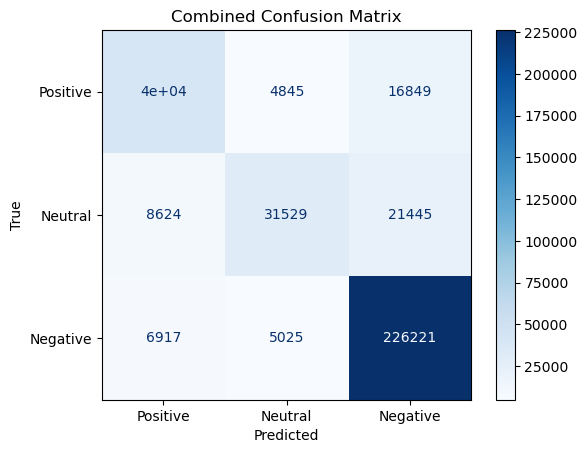

In [21]:
disp = ConfusionMatrixDisplay(confusion_matrix=train_cm, display_labels=['Positive', 'Neutral', 'Negative'])
disp.plot(cmap=plt.cm.Blues)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Combined Confusion Matrix')
plt.show()

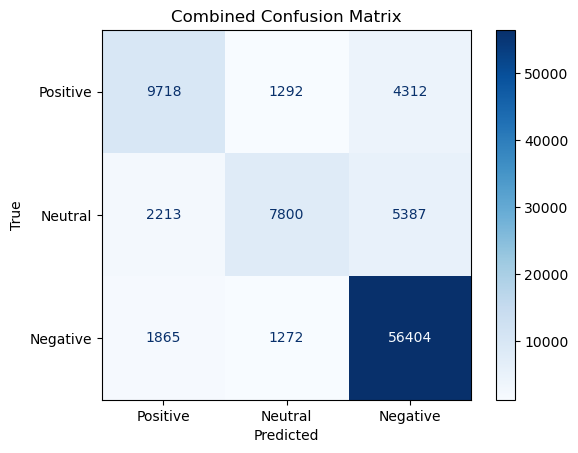

In [22]:
disp = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=['Positive', 'Neutral', 'Negative'])
disp.plot(cmap=plt.cm.Blues)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Combined Confusion Matrix')
plt.show()

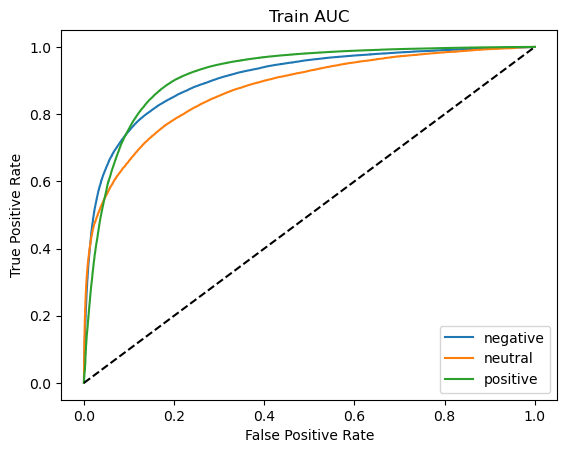

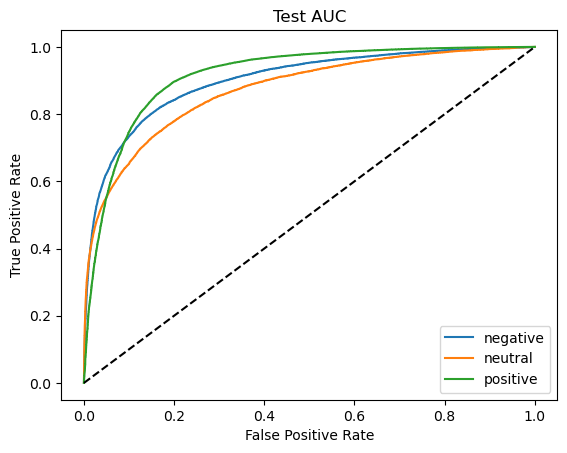

In [38]:
# AUC Plots

def plot_auc(y_true, y_score, title):
    for i in range(3):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_score[:, i])
        plt.plot(fpr, tpr, label=f"{class_labels[i]}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(title)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

plot_auc(y_train, y_train_prob, "Train AUC")
plot_auc(y_test, y_test_prob, "Test AUC")